![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTK4gQ9nhwHHaSXMHpeggWg7twwMCgb877smkRmtkmDeDoGF9Z6&usqp=CAU)
# <font color='Blue'>Ciência dos Dados na Prática</font>

# <font color='Brown'> Criando Agrupamentos de Regressões para Previsões de Valores de Imóveis  


![](https://www.clarisco.com/assets/images/gif/internet-of-things.gif)


![](https://gulfic.com/wp-content/uploads/2020/03/datacity3.gif)

## <font color='Blue'>Melhores atributos + Melhor algoritmo = Previsões Precisas com Máquinas Preditivas mais eficazes</font>

**Para isso vamos fazer um belo trabalho de Pré-Processamento e de Construção de Máquinas Preditivas**

## 1. Importanto as Bibliotecas Necessárias
![](https://cdn.dribbble.com/users/69417/screenshots/3816920/dribbble_tele2.gif)

In [6]:
# Manipulação de datasets
import pandas as pd
import numpy as np

# Para visualizar todas as colunas do dataset
pd.pandas.set_option('display.max_columns', None)

# Criar Gráficos
import matplotlib.pyplot as plt

# Pré-Processamento - Amostragem (Treino e Teste)
from sklearn.model_selection import train_test_split

# Pré-Processamento - Normalização (escalonagem)
from sklearn.preprocessing import MinMaxScaler

# Máquinas Preditivas - Algoritmos
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Máquinas Preditivas - Algoritmos para Ensemble Stacking (Agrupamento de Algoritmos)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

# Máquinas Preditivas - Avaliação das Máquinas
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error,r2_score
import math

# Para medir o tempo de Treinamento
import time

# Ignorar Warnings
import warnings
warnings.simplefilter(action='ignore')

## 2. Análise Exploratória - Somente se Conectando com os Dados
![](https://i.gifer.com/DAuB.gif)

In [ ]:
# Carregar o Dataset
data = pd.read_csv('houseprice.csv')
print(data.shape)
data.head()

## 3. Pré-Processamento dos Dados
![](https://blog.hcltechsw.com/wp-content/uploads/2020/06/iot_1.gif)

#### 3.1 Amostragem para Treino e Teste

In [8]:
# Separar os dados em Treino e Teste 
X_train, X_test, y_train, y_test = train_test_split(data,data['SalePrice'],test_size=0.25,random_state=0) 
X_train.shape, X_test.shape

((1095, 81), (365, 81))

#### 3.2 Imputação de Missing

##### a) Variáveis Numéricas

In [9]:
# Imputação de Missing - Substituir os valores missings pela moda 
# Criar uma lista com as variáveis numéricas que contém missing 

vars_with_na = [var for var in data.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O']
for var in vars_with_na:
    # Calcular a moda usando o dataset de treino 
    mode_val = X_train[var].mode()[0]
    # Substituindo pela moda
    # (em treino e teste)
    X_train[var] = X_train[var].fillna(mode_val)
    X_test[var] = X_test[var].fillna(mode_val)

##### b) Variáveis Categóricas

In [ ]:
# Criar uma lista com as variáveis categóricas que contém missing 
vars_with_na = [var for var in data.columns if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O']
# Substituindo pela nova categoria: "Missing"
X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

In [10]:
# Vamos descobrir quais são os domínios mais frequentes das variáveis categóricas  
cat_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']
def find_frequent_labels(df, var, rare_perc):
    # find_frequent_labels é uma função para encontrar os domínios mais frequentes 
    df = df.copy()
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp > rare_perc].index

for var in cat_vars:
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

In [11]:
def replace_categories(train, test, var, target):
    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index
    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')

### 3.3 Criando variáveis Temporais

In [14]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [ ]:
X_test

In [15]:
# Aplicando LOG - Escalonar
for var in ['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

### 3.4 Eliminando variáveis não explicativas

In [16]:
# capture all variables in a list
# except the target and the ID
train_vars = [var for var in X_train.columns if var not in ['Id', 'SalePrice']]
# create scaler
scaler = MinMaxScaler()
#  fit  the scaler to the train set
scaler.fit(X_train[train_vars]) 
# transform the train and test set
X_train[train_vars] = scaler.transform(X_train[train_vars])
X_test[train_vars] = scaler.transform(X_test[train_vars])
print(X_train.isnull().sum().any(),X_test.isnull().sum().any())

False False


### 3.5 Demarcação do Target

In [17]:
# capture the target (notice that the target is log transformed)
y_train = X_train['SalePrice']
y_test = X_test['SalePrice']
# drop unnecessary variables from our training and testing sets
X_train.drop(['Id', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['Id', 'SalePrice'], axis=1, inplace=True)

### 3.6 Feature Selection

#### Utilizando **Regressões** para Criar lista de Variáveis mais Importantes

Esse tipo de regressão atribui coeficiente ZERO para as Variáveis que tem pouca representatividade na Predição. Selecione um alfa adequado (o equivalente à penalidade). Quanto maior o alfa, menor será o número de variáveis selecionadas.

In [18]:
sel_= SelectFromModel(Lasso(alpha=0.005,random_state=0))
# train Lasso model and select features
sel_.fit(X_train,y_train)
# let's print the number of total and selected features
selected_feats = X_train.columns[(sel_.get_support())]
# let's print some stats
print('Total variáveis: {}'.format((X_train.shape[1])))
print('Variáveis Selecionadas: {}'.format(len(selected_feats)))
print('Variáveis com o coeficiente Zerado: {}'.format(np.sum(sel_.estimator_.coef_== 0)))

Total variáveis: 79
Variáveis Selecionadas: 25
Variáveis com o coeficiente Zerado: 54


In [19]:
X_train=X_train[selected_feats]
X_test=X_test[selected_feats]
print(X_train.shape,X_test.shape)

(1095, 25) (365, 25)


## 4. Criando as Máquinas Preditivas
![](https://mir-s3-cdn-cf.behance.net/project_modules/max_1200/7f74ab81505303.5d02aa15a7ab5.gif)

### ==> Criar umas Macros para automatizar os Parâmetros

In [20]:
# The parameters inside the models can be varied 
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
GB_model= GradientBoostingRegressor(**params) 
lin_model = Lasso(alpha=0.005, random_state=0)
RF_model = RandomForestRegressor(n_estimators=400,random_state=0)

# Get these models in a list
estimators = [('Random Forest', RF_model),
              ('Lasso', lin_model),
              ('Gradient Boosting', GB_model)]


### ==> Criando o Stacking de Regressões

In [21]:
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

## 5. Avaliando Máquinas Preditivas - Criando Visualizações Personalizadas 
![](https://images.squarespace-cdn.com/content/v1/5afdd6d5cef3721071778fc0/1567727633181-JBC9QK3Q5A1DM7KUL5YD/84d7d666822745.5b234257f1af1.gif?format=2500w)

#### Gráfico Scatter plot entre Previsões da Máquina e Valores Reais (real x predito)

In [22]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('True_Price')
    ax.set_ylabel('Predicted_Price')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + 'n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

#### Criando Gráfico com as Métricas de Avaliação de Regressões

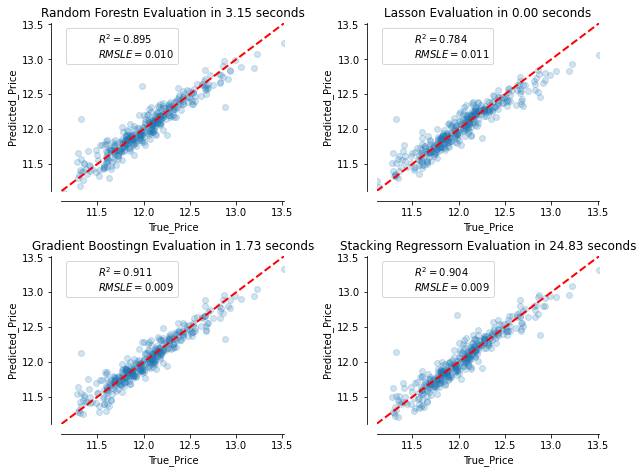

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    test_r2= r2_score(np.exp(y_test), np.exp(pred))
    
    test_rmsle=math.sqrt(mean_squared_log_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' + 
                            r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


#### Gráfico de distribuição dos Erros

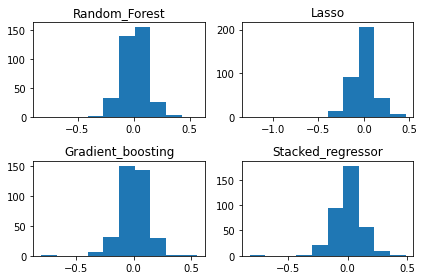

In [24]:
titles = ['Random_Forest','Lasso','Gradient_boosting','Stacked_regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()

### Verificando as Variáveis mais Importantes

Text(0.5, 1.0, 'Feature Importance')

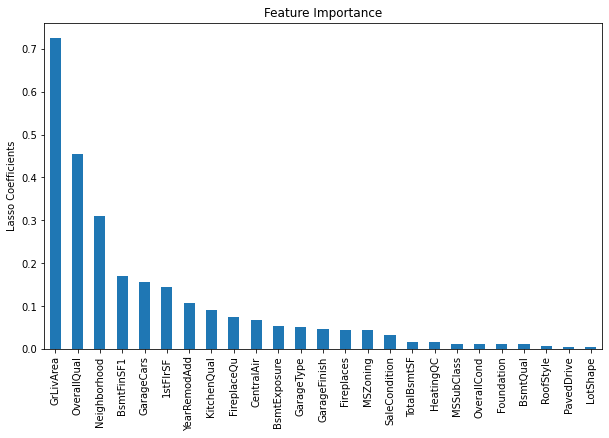

In [25]:
#let's look at the feature importance
importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = selected_feats
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(10,6),)
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

# **Resumão**
![](https://i.pinimg.com/originals/55/01/60/5501609ee45d514d1f2c4a63502045e2.gif)
 
* Nesta aula, aprendemos a **Criar Stacking de Regressões** - Ensemble de regressores
* Feature Selection com Regressão Lasso 
* Imputação de Valores Missing 
* Recategorização de Domínios Raros
* Criação de Gráficos Customizado 

#Fim

## Valeu!

### # Onde me Encontrar - Ciência dos Dados <a href="https://linktr.ee/cienciadosdados">https://linktr.ee/cienciadosdados</a>

In [4]:
from IPython.core.display import HTML
HTML('<iframe width="500" height="320" src="https://www.youtube.com/embed/9tAU8fRgq2g" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html